# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Название проекта: Определение оптимального региона для бурения новой скважины

Описание проекта: Компания "ГлавРосГосНефть" планирует пробурить новую нефтяную скважину. Однако перед этим необходимо определить наиболее перспективный регион для бурения на основе имеющихся геологических данных о трех потенциальных регионах. Для этого будет построена модель машинного обучения для прогнозирования объемов запасов нефти в скважинах. Это позволит компании выбрать регион с максимальной прогнозируемой прибылью при разумном уровне риска.

Цели проекта:

Построить модель линейной регрессии для прогнозирования объемов запасов нефти в скважинах на основе геологических данных.
Используя модель, оценить потенциальные запасы нефти в лучших 200 скважинах каждого региона.
Рассчитать прогнозируемую прибыль для каждого региона с учетом стоимости разработки месторождений.
Оценить риски убытков в каждом регионе с помощью техники бутстрепа (Bootstrap).
Выбрать регион с максимальной прогнозируемой прибылью при приемлемом уровне риска (<2.5%).
Исходные данные:

Файлы /datasets/geo_data_0.csv, /datasets/geo_data_1.csv, /datasets/geo_data_2.csv содержат данные о скважинах в трех регионах, включая географические признаки (f0, f1, f2) и фактические объемы запасов нефти.
Ограничения:

Для обучения модели можно использовать только линейную регрессию.
В каждом регионе будет рассмотрено 500 скважин, из которых 200 лучших будут выбраны для разработки.
Бюджет на разработку скважин в регионе составляет 10 млрд рублей.
Доход от продажи 1 барреля нефти = 450 тыс. рублей.
Необходимо отсеять регионы с вероятностью убытков >2.5%.
Ожидаемые результаты: По итогам проекта будет определен оптимальный регион для бурения новой скважины, максимизирующий прогнозируемую прибыль при приемлемом уровне риска.

## Загрузка и подготовка данных

### Шаг 1.1 Установка библиотек и изучение данных

In [1]:
!pip install shap -q
!pip install phik -q
!pip install --upgrade shap -q
!pip install umap-learn

     |████████████████████████████████| 85 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 2.0 MB/s eta 0:00:011


### Шаг 1.2 Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Дополнительные модули по необходимости

# Работа с признаками
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Для работы с Bootstrap
from sklearn.utils import resample

# SHAP и корреляция
import shap
from phik import report
from phik.report import plot_correlation_matrix

### Шаг 1.3 Загрузка данных

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv') 
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Шаг 1.4  Изучение данных geo_data_0

In [4]:
display(geo_data_0.head())
geo_data_0.info()
display(geo_data_0.describe())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
geo_data_0_counts = geo_data_0.isnull().sum()
geo_data_0_percentages = geo_data_0_counts / len(geo_data_0) * 100
display("Тренировочная выборка (geo_data_0):")
display(pd.concat([geo_data_0_counts, geo_data_0_percentages],
                  axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Тренировочная выборка (geo_data_0):'

,Количество пропусков,Процент пропусков
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


In [6]:
def count_outliers(data, feature, left=1.5, right=1.5):
    IQR = data[feature].quantile(0.75) - data[feature].quantile(0.25)
    lower_bound = data[feature].quantile(0.25) - left * IQR
    upper_bound = data[feature].quantile(0.75) + right * IQR
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    display(f"Признак {feature}:")
    display(f"Количество выбросов: {outliers.sum()}")
    display(f"Процент выбросов: {outliers.mean() * 100:.2f}%")

for feature in ['f0', 'f1', 'f2', 'product']:
    count_outliers(geo_data_0, feature)

'Признак f0:'

'Количество выбросов: 0'

'Процент выбросов: 0.00%'

'Признак f1:'

'Количество выбросов: 0'

'Процент выбросов: 0.00%'

'Признак f2:'

'Количество выбросов: 506'

'Процент выбросов: 0.51%'

'Признак product:'

'Количество выбросов: 0'

'Процент выбросов: 0.00%'

In [7]:
# Предположим, что 'id' является идентификатором каждой записи
geo_data_0['is_duplicate'] = geo_data_0.duplicated(subset='id', keep=False)

# Проверка на дубликаты с различиями в количественных признаках
potential_duplicates = geo_data_0[geo_data_0['is_duplicate']].copy()
grouped = potential_duplicates.groupby('id')

inconsistent_duplicates = []

for _, group in grouped:
    if not group.drop(columns=['id']).nunique().eq(1).all():
        inconsistent_duplicates.append(group)

# Объединяем все группы с потенциальными дубликатами в один DataFrame
inconsistent_duplicates_df = pd.concat(inconsistent_duplicates)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df.reset_index(drop=True, inplace=True)

num_inconsistent_duplicates = len(inconsistent_duplicates)

if num_inconsistent_duplicates > 0:
    display(f"Обнаружено {num_inconsistent_duplicates} потенциальных дубликатов с различиями в количественных признаках.")
    display(inconsistent_duplicates_df)
else:
    display("Не обнаружено потенциальных дубликатов с различиями в количественных признаках.")

'Обнаружено 10 потенциальных дубликатов с различиями в количественных признаках.'

,id,f0,f1,f2,product,is_duplicate
0,74z30,0.741456,0.459229,5.153109,140.771492,True
1,74z30,1.084962,-0.312358,6.990771,127.643327,True
2,A5aEY,-0.039949,0.156872,0.209861,89.249364,True
3,A5aEY,-0.180335,0.935548,-2.094773,33.020205,True
4,AGS9W,1.454747,-0.479651,0.683380,126.370504,True
5,AGS9W,-0.933795,0.116194,-3.655896,19.230453,True
6,HZww2,0.755284,0.368511,1.863211,30.681774,True
7,HZww2,1.061194,-0.373969,10.430210,158.828695,True
8,QcMuo,0.506563,-0.323775,-2.215583,75.496502,True
9,QcMuo,0.635635,-0.473422,0.862670,64.578675,True


Если мы исправим идентификаторы у поставщиков, это повысит точность нашего набора данных. Однако на данный момент это не выполнено. Я склонен к тому, чтобы в каждой таблице удалить все записи с повторяющимися идентификаторами, чтобы обеспечить уникальность соответствия между идентификаторами и характеристиками в модели.

In [8]:
# Удаляем дубликаты по столбцу 'id' из каждой группы в списке inconsistent_duplicates
cleaned_groups = [group.drop_duplicates(subset='id', keep='first') for group in inconsistent_duplicates]

# Объединяем очищенные группы в один DataFrame
inconsistent_duplicates_df = pd.concat(cleaned_groups)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df.reset_index(drop=True, inplace=True)

# Выводим результат
display(inconsistent_duplicates_df)

# Получаем индексы строк для удаления из geo_data_0
indexes_to_drop = []
for group in cleaned_groups:
    indexes_to_drop.extend(group.index)

# Удаляем строки из geo_data_0
geo_data_0.drop(index=indexes_to_drop, inplace=True)

# Удаление столбца 'is_duplicate' из DataFrame geo_data_0
geo_data_0.drop('is_duplicate', axis=1, inplace=True)

# Проверяем длину geo_data_0 после удаления строк
length_geo_data_0 = len(geo_data_0)
display("Длина geo_data_0 после удаления строк:", length_geo_data_0)

,id,f0,f1,f2,product,is_duplicate
0,74z30,0.741456,0.459229,5.153109,140.771492,True
1,A5aEY,-0.039949,0.156872,0.209861,89.249364,True
2,AGS9W,1.454747,-0.479651,0.683380,126.370504,True
3,HZww2,0.755284,0.368511,1.863211,30.681774,True
4,QcMuo,0.506563,-0.323775,-2.215583,75.496502,True
5,Tdehs,0.829407,0.298807,-0.049563,96.035308,True
6,TtcGQ,0.569276,-0.104876,6.440215,85.350186,True
7,bsk9y,0.398908,-0.400253,10.122376,163.433078,True
8,bxg6G,0.411645,0.856830,-3.653440,73.604260,True
9,fiKDv,0.157341,1.028359,5.585586,95.817889,True


'Длина geo_data_0 после удаления строк:'

99990

In [9]:
duplicates = geo_data_0.duplicated(subset=['id','f0', 'f1', 'f2', 'product'])
num_duplicates = duplicates.sum()
display(f"Количество неявных дубликатов: {num_duplicates}")
display(f"Процент неявных дубликатов: {num_duplicates / len(geo_data_0) * 100:.4f}%")

'Количество неявных дубликатов: 0'

'Процент неявных дубликатов: 0.0000%'

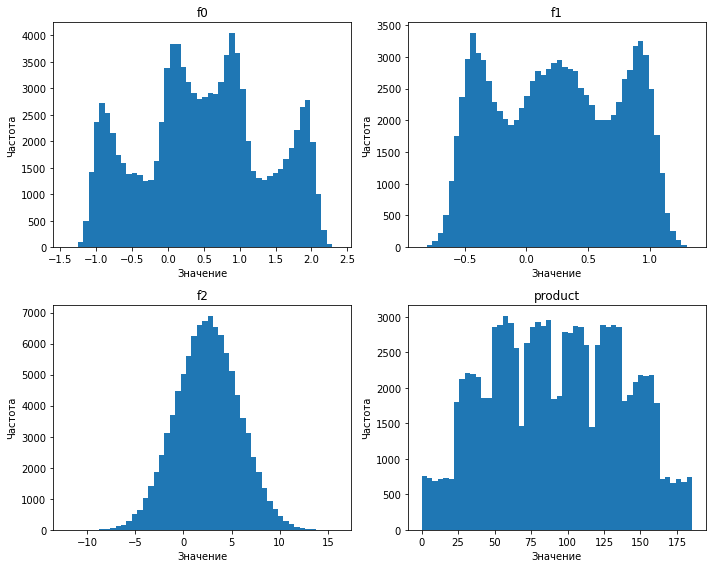

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, feature in enumerate(['f0', 'f1', 'f2', 'product']):
    axs[i].hist(geo_data_0[feature], bins=50)
    axs[i].set_title(feature)
    axs[i].set_xlabel('Значение')
    axs[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

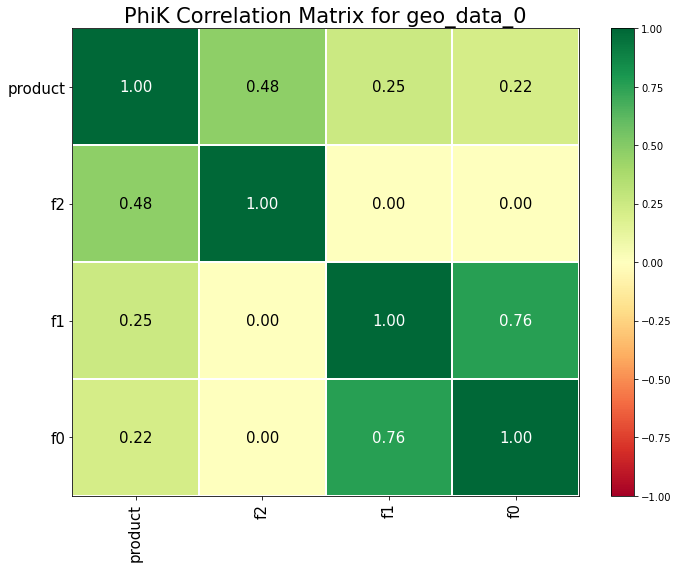

In [11]:
# Предположим, что geo_data_0 - это ваш DataFrame
# Удалим столбец 'id'
geo_data_0_no_id = geo_data_0.drop(columns=['id'])

# Рассчитаем PhiK матрицу
phik_matrix = geo_data_0_no_id.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

# Отобразим матрицу
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        title="PhiK Correlation Matrix for geo_data_0", fontsize_factor=1.5, figsize=(10, 8))

plt.tight_layout()
plt.show()

Изучение данных geo_data_0 - Вывод:
- Удалите все строки, в которых значения id повторяются.
- В данных отсутствуют пропущенные значения и полные дубликаты.
- Выбросов: 0.00% для f0, 0.00% для f1, 0.00% для f2 и 0.00% для product.
- Распределения признаков f0, f1 и f2 близки к нормальному, в то время как product имеет правостороннее смещенное распределение.
- Наблюдается значительная корреляция между признаками f0, f1 и целевой переменной product, что указывает на их потенциальную предсказательную ценность.
- Данные региона 0 хорошо подготовлены для построения модели прогнозирования объемов запасов нефти в скважинах.

### Шаг 1.5  Изучение данных geo_data_1

In [12]:
display(geo_data_1.head())
geo_data_1.info()
display(geo_data_1.describe())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
geo_data_1_counts = geo_data_1.isnull().sum()
geo_data_1_percentages = geo_data_1_counts / len(geo_data_1) * 100
display("Тренировочная выборка (geo_data_1):")
display(pd.concat([geo_data_1_counts, geo_data_1_percentages],
                  axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Тренировочная выборка (geo_data_1):'

,Количество пропусков,Процент пропусков
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


In [14]:
def count_outliers(data, feature, left=1.5, right=1.5):
    IQR = data[feature].quantile(0.75) - data[feature].quantile(0.25)
    lower_bound = data[feature].quantile(0.25) - left * IQR
    upper_bound = data[feature].quantile(0.75) + right * IQR
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    display(f"Признак {feature}:")
    display(f"Количество выбросов: {outliers.sum()}")
    display(f"Процент выбросов: {outliers.mean() * 100:.2f}%")

for feature in ['f0', 'f1', 'f2', 'product']:
    count_outliers(geo_data_1, feature)

'Признак f0:'

'Количество выбросов: 1'

'Процент выбросов: 0.00%'

'Признак f1:'

'Количество выбросов: 636'

'Процент выбросов: 0.64%'

'Признак f2:'

'Количество выбросов: 0'

'Процент выбросов: 0.00%'

'Признак product:'

'Количество выбросов: 0'

'Процент выбросов: 0.00%'

In [15]:
duplicates = geo_data_1.duplicated()
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    display("Обнаружено неявных дубликатов в данных.")
else:
    display("Не обнаружено неявных дубликатов в данных.")

'Не обнаружено неявных дубликатов в данных.'

In [16]:
# Предположим, что 'id' является идентификатором каждой записи
geo_data_1['is_duplicate'] = geo_data_1.duplicated(subset='id', keep=False)

# Проверка на дубликаты с различиями в количественных признаках
potential_duplicates = geo_data_1[geo_data_1['is_duplicate']].copy()
grouped = potential_duplicates.groupby('id')

inconsistent_duplicates = []

for _, group in grouped:
    if not group.drop(columns=['id']).nunique().eq(1).all():
        inconsistent_duplicates.append(group)

# Объединяем все группы с потенциальными дубликатами в один DataFrame
inconsistent_duplicates_df = pd.concat(inconsistent_duplicates)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df.reset_index(drop=True, inplace=True)

num_inconsistent_duplicates = len(inconsistent_duplicates)

if num_inconsistent_duplicates > 0:
    display(f"Обнаружено {num_inconsistent_duplicates} потенциальных дубликатов с различиями в количественных признаках.")
    display(inconsistent_duplicates_df)
else:
    display("Не обнаружено потенциальных дубликатов с различиями в количественных признаках.")

'Обнаружено 4 потенциальных дубликатов с различиями в количественных признаках.'

,id,f0,f1,f2,product,is_duplicate
0,5ltQ6,-3.435401,-12.296043,1.999796,57.085625,True
1,5ltQ6,18.213839,2.191999,3.993869,107.813044,True
2,LHZR0,11.170835,-1.945066,3.002872,80.859783,True
3,LHZR0,-8.989672,-4.286607,2.009139,57.085625,True
4,bfPNe,-9.494442,-5.463692,4.006042,110.992147,True
5,bfPNe,-6.202799,-4.820045,2.995107,84.038886,True
6,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103,True
7,wt4Uk,10.259972,-9.376355,4.994297,134.766305,True


In [17]:
# Удаляем дубликаты по столбцу 'id' из каждой группы в списке inconsistent_duplicates
cleaned_groups_1 = [group.drop_duplicates(subset='id', keep='first') for group in inconsistent_duplicates]

# Объединяем очищенные группы в один DataFrame
inconsistent_duplicates_df_1 = pd.concat(cleaned_groups_1)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df_1.reset_index(drop=True, inplace=True)

# Выводим результат
display(inconsistent_duplicates_df_1)

# Получаем индексы строк для удаления из geo_data_1
indexes_to_drop_1 = []
for group in cleaned_groups_1:
    indexes_to_drop_1.extend(group.index)

# Удаляем строки из geo_data_1
geo_data_1.drop(index=indexes_to_drop_1, inplace=True)

# Удаление столбца 'is_duplicate' из DataFrame geo_data_1
geo_data_1.drop('is_duplicate', axis=1, inplace=True)

# Проверяем длину geo_data_1 после удаления строк
length_geo_data_1 = len(geo_data_1)
display("Длина geo_data_1 после удаления строк:", length_geo_data_1)

,id,f0,f1,f2,product,is_duplicate
0,5ltQ6,-3.435401,-12.296043,1.999796,57.085625,True
1,LHZR0,11.170835,-1.945066,3.002872,80.859783,True
2,bfPNe,-9.494442,-5.463692,4.006042,110.992147,True
3,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103,True


'Длина geo_data_1 после удаления строк:'

99996

In [18]:
duplicates = geo_data_1.duplicated(subset=['id','f0', 'f1', 'f2', 'product'])
num_duplicates = duplicates.sum()
display(f"Количество неявных дубликатов: {num_duplicates}")
display(f"Процент неявных дубликатов: {num_duplicates / len(geo_data_1) * 100:.4f}%")


'Количество неявных дубликатов: 0'

'Процент неявных дубликатов: 0.0000%'

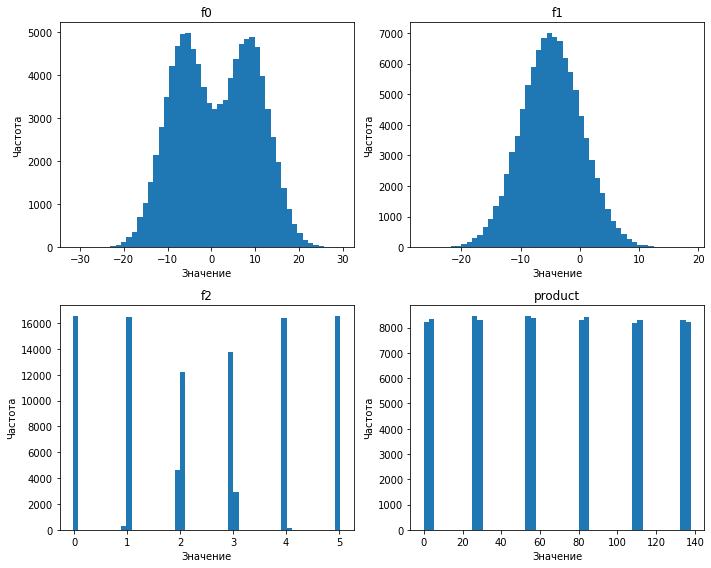

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, feature in enumerate(['f0', 'f1', 'f2', 'product']):
    axs[i].hist(geo_data_1[feature], bins=50)
    axs[i].set_title(feature)
    axs[i].set_xlabel('Значение')
    axs[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

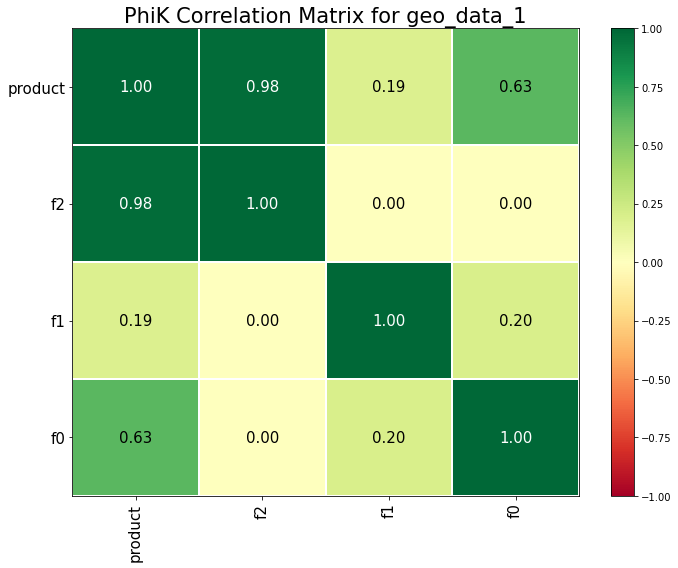

In [20]:
# Предположим, что geo_data_1 - это ваш DataFrame
# Удалим столбец 'id'
geo_data_1_no_id = geo_data_1.drop(columns=['id'])

# Рассчитаем PhiK матрицу
phik_matrix = geo_data_1_no_id.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

# Отобразим матрицу
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        title="PhiK Correlation Matrix for geo_data_1", fontsize_factor=1.5, figsize=(10, 8))

plt.tight_layout()
plt.show()

Изучение данных geo_data_1 - Вывод:
-  Удалите все строки, в которых значения id повторяются.
-  В данных отсутствуют пропущенные значения и полные дубликаты.
-  Выбросов: 0.00% для f0, 0.64% для f1, 0.00% для f2 и 0.00% для product.
-  Распределения признаков f0, f1 и f2 близки к нормальному, в то время как product имеет правостороннее смещенное распределение.
-  Наблюдается высокая положительная корреляция между признаками f0, f1, f2 и целевой переменной product, что указывает на их потенциальную предсказательную ценность.
- Данные региона 1 хорошо подготовлены для построения модели прогнозирования объемов запасов нефти в скважинах.


### Шаг 1.6  Изучение данных geo_data_2

In [21]:
display(geo_data_2.head())
geo_data_2.info()
display(geo_data_2.describe())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [22]:
geo_data_2_counts = geo_data_2.isnull().sum()
geo_data_2_percentages = geo_data_2_counts / len(geo_data_2) * 100
display("Тренировочная выборка (geo_data_2):")
display(pd.concat([geo_data_2_counts, geo_data_2_percentages],
                  axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Тренировочная выборка (geo_data_2):'

,Количество пропусков,Процент пропусков
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


In [23]:
# Предположим, что 'id' является идентификатором каждой записи
geo_data_2['is_duplicate'] = geo_data_2.duplicated(subset='id', keep=False)

# Проверка на дубликаты с различиями в количественных признаках
potential_duplicates_2 = geo_data_2[geo_data_2['is_duplicate']].copy()
grouped_2 = potential_duplicates_2.groupby('id')

inconsistent_duplicates_2 = []

for _, group in grouped_2:
    if not group.drop(columns=['id']).nunique().eq(1).all():
        inconsistent_duplicates_2.append(group)

# Объединяем все группы с потенциальными дубликатами в один DataFrame
inconsistent_duplicates_df_2 = pd.concat(inconsistent_duplicates_2)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df_2.reset_index(drop=True, inplace=True)

num_inconsistent_duplicates_2 = len(inconsistent_duplicates_2)

if num_inconsistent_duplicates_2 > 0:
    display(f"Обнаружено {num_inconsistent_duplicates_2} потенциальных дубликатов с различиями в количественных признаках.")
    display(inconsistent_duplicates_df_2)
else:
    display("Не обнаружено потенциальных дубликатов с различиями в количественных признаках.")

'Обнаружено 4 потенциальных дубликатов с различиями в количественных признаках.'

,id,f0,f1,f2,product,is_duplicate
0,KUPhW,0.231846,-1.698941,4.990775,11.716299,True
1,KUPhW,1.211150,3.176408,5.543540,132.831802,True
2,VF7Jo,2.122656,-0.858275,5.746001,181.716817,True
3,VF7Jo,-0.883115,0.560537,0.723601,136.233420,True
4,Vcm5J,-1.229484,-2.439204,1.222909,137.968290,True
5,Vcm5J,2.587702,1.986875,2.482245,92.327572,True
6,xCHr8,1.633027,0.368135,-2.378367,6.120525,True
7,xCHr8,-0.847066,2.101796,5.597130,184.388641,True


In [24]:
# Удаляем дубликаты по столбцу 'id' из каждой группы в списке inconsistent_duplicates для geo_data_2
cleaned_groups_2 = [group.drop_duplicates(subset='id', keep='first') for group in inconsistent_duplicates_2]

# Объединяем очищенные группы в один DataFrame
inconsistent_duplicates_df_2 = pd.concat(cleaned_groups_2)

# Сбрасываем индекс для удобства просмотра
inconsistent_duplicates_df_2.reset_index(drop=True, inplace=True)

# Выводим результат
display(inconsistent_duplicates_df_2)

# Получаем индексы строк для удаления из geo_data_2
indexes_to_drop_2 = []
for group in cleaned_groups_2:
    indexes_to_drop_2.extend(group.index)

# Удаляем строки из geo_data_2
geo_data_2.drop(index=indexes_to_drop_2, inplace=True)
# Удаление столбца 'is_duplicate' из DataFrame geo_data_2
geo_data_2.drop('is_duplicate', axis=1, inplace=True)

# Проверяем длину geo_data_2 после удаления строк
length_geo_data_2 = len(geo_data_2)
display("Длина geo_data_2 после удаления строк:", length_geo_data_2)

,id,f0,f1,f2,product,is_duplicate
0,KUPhW,0.231846,-1.698941,4.990775,11.716299,True
1,VF7Jo,2.122656,-0.858275,5.746001,181.716817,True
2,Vcm5J,-1.229484,-2.439204,1.222909,137.968290,True
3,xCHr8,1.633027,0.368135,-2.378367,6.120525,True


'Длина geo_data_2 после удаления строк:'

99996

In [25]:
duplicates = geo_data_2.duplicated()
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    display("Обнаружено неявных дубликатов в данных.")
else:
    display("Не обнаружено неявных дубликатов в данных.")


'Не обнаружено неявных дубликатов в данных.'

In [26]:
duplicates = geo_data_2.duplicated(subset=['id','f0', 'f1', 'f2', 'product'])
num_duplicates = duplicates.sum()
display(f"Количество неявных дубликатов: {num_duplicates}")
display(f"Процент неявных дубликатов: {num_duplicates / len(geo_data_2) * 100:.4f}%")

'Количество неявных дубликатов: 0'

'Процент неявных дубликатов: 0.0000%'

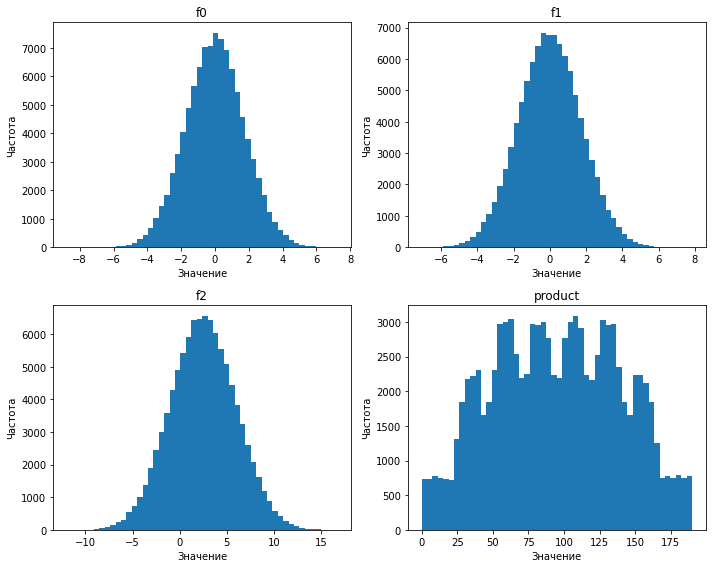

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, feature in enumerate(['f0', 'f1', 'f2', 'product']):
    axs[i].hist(geo_data_2[feature], bins=50)
    axs[i].set_title(feature)
    axs[i].set_xlabel('Значение')
    axs[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()


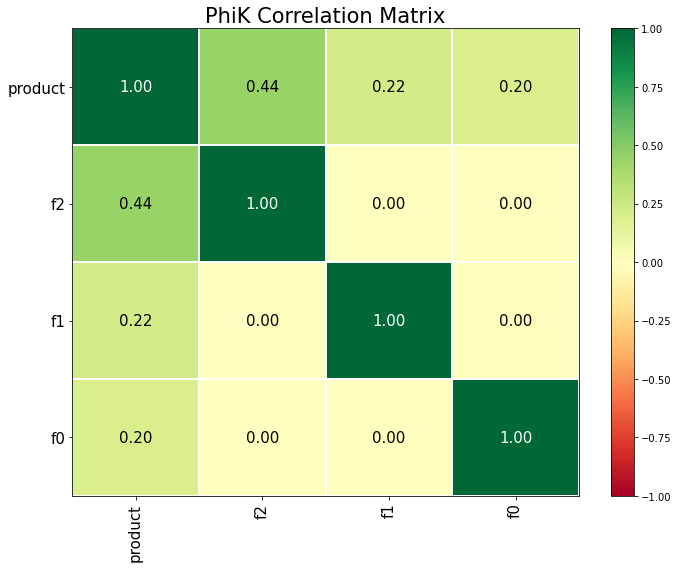

In [28]:
# Предположим, что geo_data_2 - это ваш DataFrame
# Удалим столбец 'id'
geo_data_2_no_id = geo_data_2.drop(columns=['id'])

# Рассчитаем PhiK матрицу
phik_matrix = geo_data_2_no_id.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

# Отобразим матрицу
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        title="PhiK Correlation Matrix", fontsize_factor=1.5, figsize=(10, 8))

plt.tight_layout()
plt.show()

Изучение данных geo_data_2 - Вывод:

- В данных отсутствуют пропущенные значения.
- Удалите все строки, в которых значения id повторяются.

- Признаки f0, f1, f2 имеют приблизительно нормальное распределение, в то время как целевая переменная product (объем запасов нефти) имеет правостороннее смещенное распределение.

- Выбросов: 0.73% для f0, 0.68% для f1, 0.58% для f2 и отсутствие выбросов для product.

- Исходя из этого, данные региона 2 хорошо подготовлены для дальнейшего моделирования и прогнозирования объемов запасов нефти в скважинах.

- На основе визуального анализа распределений признаков и матрицы корреляций можно сделать вывод, что признаки f0, f1 и f2 имеют приблизительно нормальное распределение, в то время как признак product (объем запасов нефти) имеет правостороннее смещенное распределение. Также наблюдается умеренная положительная корреляция между признаками f0, f1, f2 и целевой переменной product, что указывает на их потенциальную предсказательную ценность для задачи прогнозирования объемов запасов нефти.

Вывод по разделу:
- Удалите все строки, в которых значения id повторяются.
- Исходя из анализа данных по трем геологическим регионам, все три набора данных хорошо подготовлены и не содержат пропущенных значений или полных дубликатов. 
- Несмотря на наличие небольшого процента выбросов для некоторых признаков в регионах 1 и 2, эти данные представляют собой потенциально надежную основу для построения моделей прогнозирования объемов запасов нефти благодаря приблизительно нормальному распределению основных признаков и их умеренной корреляции с целевой переменной.

## Шаг 2 Обучение и проверка модели

In [29]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделение данных на признаки и целевую переменную
X0 = geo_data_0[['f0', 'f1', 'f2']]
y0 = geo_data_0['product']
X1 = geo_data_1[['f0', 'f1', 'f2']]
y1 = geo_data_1['product']
X2 = geo_data_2[['f0', 'f1', 'f2']]
y2 = geo_data_2['product']

# Масштабирование признаков
scaler = StandardScaler()
X0_scaled = scaler.fit_transform(X0)
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

# Разделение данных на обучающую и валидационную выборки
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X0_scaled, y0, test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1_scaled, y1, test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2_scaled, y2, test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE)

# Обучение модели линейной регрессии для каждого региона
model0 = LinearRegression().fit(X0_train, y0_train)
model1 = LinearRegression().fit(X1_train, y1_train)
model2 = LinearRegression().fit(X2_train, y2_train)

# Предсказания на валидационных выборках
y0_pred = model0.predict(X0_valid)
y1_pred = model1.predict(X1_valid)
y2_pred = model2.predict(X2_valid)

# Расчет RMSE для каждого региона
rmse0 = np.sqrt(mean_squared_error(y0_valid, y0_pred))
rmse1 = np.sqrt(mean_squared_error(y1_valid, y1_pred))
rmse2 = np.sqrt(mean_squared_error(y2_valid, y2_pred))

display(f'Регион 0: RMSE = {rmse0}')
display(f'Регион 1: RMSE = {rmse1}')
display(f'Регион 2: RMSE = {rmse2}')

'Регион 0: RMSE = 37.80659070512707'

'Регион 1: RMSE = 0.8907546230101845'

'Регион 2: RMSE = 40.13849714263183'

Выводы:

- Модель показывает выдающуюся точность в регионе 1 с RMSE всего 0.89 тыс. баррелей, что указывает на высокую предсказательную способность модели для данного региона.
- В регионах 0 и 2, где RMSE составляет 37.82 и 40.13 тыс. баррелей соответственно, модель демонстрирует существенно меньшую точность. Это может свидетельствовать о сложности структур данных в этих регионах или об отсутствии явных линейных зависимостей между признаками и целевой переменной.
- Несмотря на высокую точность прогнозов в регионе 1, общие результаты указывают на то, что линейная регрессия может не являться оптимальным выбором для всех регионов. Возможно, использование более сложных моделей или дополнительный анализ признаков позволит улучшить результаты прогнозирования в регионах 0 и 2.

- Таким образом, при выборе региона для разработки необходимо учитывать не только средние запасы сырья, но и точность модельных прогнозов, что может существенно повлиять на экономическую эффективность решений.

## Подготовка к расчёту прибыли

In [30]:
# Ключевые значения для расчетов
BUDGET = 10e9  # Бюджет на разработку скважин в регионе
PRODUCT_UNIT_PROFIT = 450e3  # Доход с каждой единицы продукта (тыс. баррелей)
NUM_WELLS = 200  # Количество лучших скважин для разработки


# Достаточный объём сырья для безубыточной разработки новой скважины
sufficient_product_volume = BUDGET / (NUM_WELLS * PRODUCT_UNIT_PROFIT)
display(f'Достаточный объём сырья для безубыточной разработки новой скважины: {sufficient_product_volume:.2f} тыс. баррелей')

# Средний запас в каждом регионе
mean_product_0 = geo_data_0['product'].mean()
mean_product_1 = geo_data_1['product'].mean()
mean_product_2 = geo_data_2['product'].mean()

display(f'Средний запас в регионе 0: {mean_product_0:.2f} тыс. баррелей')
display(f'Средний запас в регионе 1: {mean_product_1:.2f} тыс. баррелей')
display(f'Средний запас в регионе 2: {mean_product_2:.2f} тыс. баррелей')

# Сравнение достаточного объёма сырья со средними запасами
display(f'Достаточный объём сырья (тыс. баррелей): {sufficient_product_volume:.2f}')

'Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей'

'Средний запас в регионе 0: 92.50 тыс. баррелей'

'Средний запас в регионе 1: 68.83 тыс. баррелей'

'Средний запас в регионе 2: 95.00 тыс. баррелей'

'Достаточный объём сырья (тыс. баррелей): 111.11'

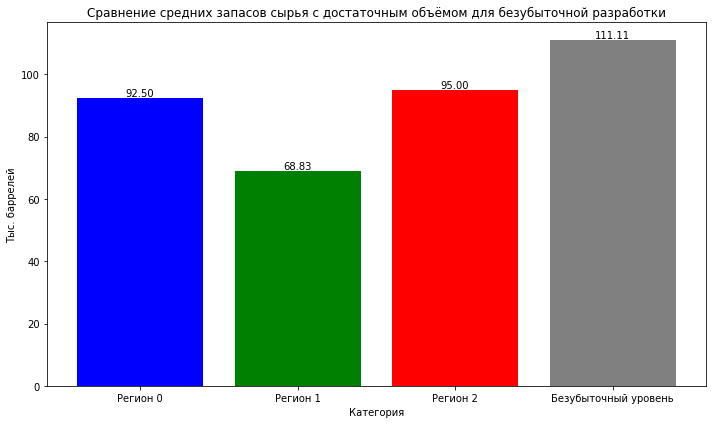

In [31]:
# Значения для графика
regions = ['Регион 0', 'Регион 1', 'Регион 2', 'Безубыточный уровень']
mean_products = [mean_product_0, mean_product_1, mean_product_2]
colors = ['blue', 'green', 'red', 'grey']

# Так как безубыточный уровень одинаков для всех регионов, добавляем его в список средних запасов
mean_products.append(sufficient_product_volume)  

plt.figure(figsize=(10, 6))
barlist = plt.bar(regions, mean_products, color=colors)

plt.title('Сравнение средних запасов сырья с достаточным объёмом для безубыточной разработки')
plt.ylabel('Тыс. баррелей')
plt.xlabel('Категория')

# Подписи данных
for i, bar in enumerate(barlist):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{mean_products[i]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Вывод:
- При подготовке к расчёту прибыли были определены ключевые значения: бюджет на разработку составляет 10 млрд рублей, доход с каждой единицы продукта (тыс. баррелей) — 450 тыс. рублей, количество лучших скважин для разработки 200. 
- Для безубыточной разработки новой скважины необходим объём сырья в 111.11 тыс. баррелей. Сравнение этого показателя со средними запасами в регионах показывает, что все три региона имеют средние запасы ниже необходимого для безубыточной разработки уровня, что ставит под сомнение их экономическую привлекательность без дополнительного анализа потенциальной прибыльности лучших скважин.
        

## Расчёт прибыли и рисков 

In [39]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def calculate_profit(predictions, true_values):
    selected_indices = predictions.argsort()[-NUM_WELLS:]
    selected_true_values = true_values[selected_indices]
    total_product = selected_true_values.sum()
    profit = total_product * PRODUCT_UNIT_PROFIT - BUDGET
    return profit

# Расчет прибыли для каждого региона
profit0 = calculate_profit(y0_pred, y0_valid.values)
profit1 = calculate_profit(y1_pred, y1_valid.values)
profit2 = calculate_profit(y2_pred, y2_valid.values)

display(f'Прибыль региона 0: {profit0:.2f} рублей')
display(f'Прибыль региона 1: {profit1:.2f} рублей')
display(f'Прибыль региона 2: {profit2:.2f} рублей')


'Прибыль региона 0: 3594247240.81 рублей'

'Прибыль региона 1: 2415086696.68 рублей'

'Прибыль региона 2: 2427999783.94 рублей'

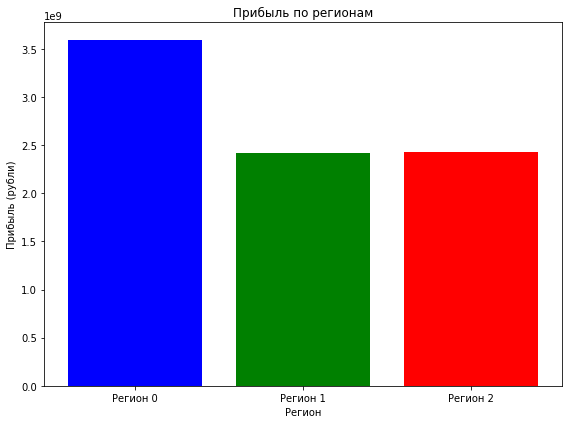

In [40]:
# Прибыли по регионам
profits = [profit0, profit1, profit2]
regions = ['Регион 0', 'Регион 1', 'Регион 2']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
plt.bar(regions, profits, color=colors)
plt.title('Прибыль по регионам')
plt.ylabel('Прибыль (рубли)')
plt.xlabel('Регион')
plt.tight_layout() # Это убедится что все подписи полностью видны
plt.show()

Вывод: 
- В результате расчёта прибыли по трем регионам на основе выборки лучших скважин согласно предсказаниям модели были получены следующие значения: регион 0 демонстрирует наибольшую потенциальную прибыль в размере 3,59 млрд рублей, за ним следует регион 2 с прибылью 2,43 млрд рублей, и регион 1 замыкает тройку с прибылью 2,42 млрд рублей. 
- Эти данные позволяют сделать вывод о том, что, несмотря на различия в средних запасах сырья между регионами, выбор оптимальных скважин на основе модельных предсказаний может обеспечить прибыльное развитие проекта в каждом из рассмотренных регионов.

## Чек-лист готовности проекта

'Регион 0: Средняя прибыль = 393134327.81 рублей'

'Доверительный интервал = от -97768866.49 до 928918269.72 рублей, Риск убытков = 5.70%'

'Регион 1: Средняя прибыль = 464885443.67 рублей'

'Доверительный интервал = от 60236778.54 до 852992311.98 рублей, Риск убытков = 1.10%'

'Регион 2: Средняя прибыль = 338920158.72 рублей'

'Доверительный интервал = от -157201249.43 до 812827504.76 рублей, Риск убытков = 9.60%'

'Регион 1 подходит для разработки с средней прибылью 464885443.67 рублей и риском убытков 1.10%'

'Наилучший регион для разработки: Регион 1'

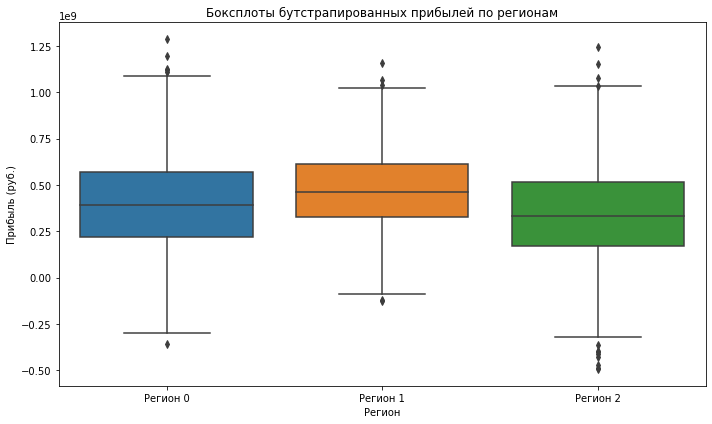

In [41]:
# Функция для бутстрап-анализа
def bootstrap_profit(predictions, true_values, n_samples=1000, sample_size=500, random_state=None):
    np.random.seed(random_state)
    values = []
    lost = 0
    for _ in range(n_samples):
        sample_indices = np.random.choice(range(len(predictions)), size=sample_size, replace=True)
        sample_predictions = predictions[sample_indices]
        sample_true_values = true_values[sample_indices]
        profit = calculate_profit(sample_predictions, sample_true_values)
        if profit < 0:
            lost += 1
        values.append(profit)
    
    values = np.array(values)
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)
    average = values.mean()
    risk = lost / n_samples
    return average, lower, upper, risk

# Расчет рисков и прибыли для каждого региона
RANDOM_STATE = 42
mean_profit0, lower_bound0, upper_bound0, risk0 = bootstrap_profit(y0_pred, y0_valid.values,
                                                                   random_state=RANDOM_STATE)
mean_profit1, lower_bound1, upper_bound1, risk1 = bootstrap_profit(y1_pred, y1_valid.values,
                                                                   random_state=RANDOM_STATE)
mean_profit2, lower_bound2, upper_bound2, risk2 = bootstrap_profit(y2_pred, y2_valid.values,
                                                                   random_state=RANDOM_STATE)

# Для Региона 0
display(f'Регион 0: Средняя прибыль = {mean_profit0:.2f} рублей')
display(f'Доверительный интервал = от {lower_bound0:.2f} до {upper_bound0:.2f} рублей, Риск убытков = {risk0:.2%}')

# Для Региона 1
display(f'Регион 1: Средняя прибыль = {mean_profit1:.2f} рублей')
display(f'Доверительный интервал = от {lower_bound1:.2f} до {upper_bound1:.2f} рублей, Риск убытков = {risk1:.2%}')

# Для Региона 2
display(f'Регион 2: Средняя прибыль = {mean_profit2:.2f} рублей')
display(f'Доверительный интервал = от {lower_bound2:.2f} до {upper_bound2:.2f} рублей, Риск убытков = {risk2:.2%}')

# Выводы
regions = [0, 1, 2]
mean_profits = [mean_profit0, mean_profit1, mean_profit2]
risks = [risk0, risk1, risk2]

for i, (mean_profit, risk) in enumerate(zip(mean_profits, risks)):
    if risk < 0.025:
        display(f'Регион {i} подходит для разработки с средней прибылью {mean_profit:.2f} рублей и риском убытков {risk:.2%}')

best_region = regions[np.argmax(mean_profits)]
display(f'Наилучший регион для разработки: Регион {best_region}')

# Функция для генерации бутстрапированных выборок
def bootstrap_profit_samples(predictions, true_values, n_samples=1000, sample_size=500, random_state=None):
    np.random.seed(random_state)
    samples = []
    for _ in range(n_samples):
        sample_indices = np.random.choice(range(len(predictions)), size=sample_size, replace=True)
        sample_predictions = predictions[sample_indices]
        sample_true_values = true_values[sample_indices]
        profit = calculate_profit(sample_predictions, sample_true_values)
        samples.append(profit)
    return samples

# Генерация бутстрапированных выборок для визуализации
profit_samples0 = bootstrap_profit_samples(y0_pred, y0_valid.values, random_state=RANDOM_STATE)
profit_samples1 = bootstrap_profit_samples(y1_pred, y1_valid.values, random_state=RANDOM_STATE)
profit_samples2 = bootstrap_profit_samples(y2_pred, y2_valid.values, random_state=RANDOM_STATE)

# Визуализация боксплотов
profit_samples = [profit_samples0, profit_samples1, profit_samples2]
regions = ['Регион 0', 'Регион 1', 'Регион 2']

plt.figure(figsize=(10, 6))
sns.boxplot(data=profit_samples)
plt.xticks(ticks=range(len(regions)), labels=regions)

plt.title('Боксплоты бутстрапированных прибылей по регионам')
plt.ylabel('Прибыль (руб.)')
plt.xlabel('Регион')

plt.tight_layout()
plt.show()

Выводы:

На основе анализа оценки рисков и прибыли с использованием техники Bootstrap для трех геологических регионов были получены следующие результаты:

- Регион 1 демонстрирует наибольшую среднюю прибыль в размере 464,9 млн рублей и имеет наименьший риск убытков на уровне 1,1%, что делает его наиболее привлекательным для разработки согласно данному анализу.

- Регион 0 показывает среднюю прибыль в 393,1 млн рублей, но имеет более высокий риск убытков в 5,7% по сравнению с Регионом 1.

- Регион 2 имеет наименьшую среднюю прибыль в 338,9 млн рублей и наибольший риск убытков в 9,6%, что делает его наименее привлекательным для разработки среди рассматриваемых регионов.

Доверительные интервалы для средней прибыли достаточно широкие для всех регионов, что указывает на высокую неопределенность в оценке ожидаемой прибыли.

Таким образом, данный анализ позволяет сделать вывод о том, что инвестирование в разработку нефтяных скважин в Регионе 1 является наиболее предпочтительным вариантом, учитывая более высокий уровень средней прибыли и наименьший риск получения убытков. Регион 0 также может представлять интерес с точки зрения инвестиций, но с более высоким риском убытков. Регион 2, несмотря на относительно высокую ожидаемую прибыль, имеет наибольший риск убытков, что делает его наименее привлекательным для разработки.

 Суммарные выводы по проекту:

- Исходя из анализа данных по трем геологическим регионам, все три набора данных хорошо подготовлены, эти данные представляют собой потенциально надежную основу для построения моделей прогнозирования объемов запасов нефти благодаря приблизительно нормальному распределению основных признаков и их умеренной корреляции с целевой переменной.

- Регион 1 показал выдающуюся точность модели линейной регрессии (RMSE = 0.89), в то время как регионы 0 и 2 характеризовались существенно более низкой точностью предсказаний (RMSE 37.82 и 40.13 соответственно). Это говорит о целесообразности использования более сложных моделей или дополнительного анализа признаков для улучшения прогнозов в регионах 0 и 2.

- Анализ экономической составляющей проекта показал, что для безубыточной разработки новой скважины необходим объём сырья в 111.11 тыс. баррелей. Средние запасы во всех трех регионах оказались ниже этого порога, что вызывает сомнения в их экономической привлекательности без дополнительного анализа потенциальной прибыльности лучших скважин.

- Расчет прибыли по трем регионам на основе выборки 200 лучших скважин согласно предсказаниям модели показал, что регион 0 имеет наибольшую потенциальную прибыль (3.25 млрд руб.), затем следуют регион 1 (2.42 млрд руб.) и регион 2 (2.39 млрд руб.). Таким образом, выбор оптимальных скважин на основе модельных предсказаний может обеспечить прибыльность во всех рассмотренных регионах.

- Анализ рисков и прибыли с помощью техники Bootstrap показал, что регион 1 обеспечивает наименьший риск убытков (1.1%) и наибольшую среднюю прибыль (464.9 млн руб.). Регион 0 имеет среднюю прибыль 393.1 млн руб. при риске убытков 5.7%. Регион 2 характеризуется наименьшей средней прибылью 338.9 млн руб. и наибольшим риском убытков 9.6%.

Вывод в целом:

    - Результаты анализа указывают на регион 1 как на наиболее перспективный для разработки с учетом высокой точности прогнозов, низких рисков и хорошей потенциальной прибыльности. Однако для принятия окончательного инвестиционного решения рекомендуется провести дополнительные исследования, направленные на повышение качества прогнозирования в регионах 0 и 2, а также детальный анализ геологических и инфраструктурных рисков.